<a href="https://colab.research.google.com/github/kfahn22/computer-vision-course/blob/synthetic-data-creation-lung-images/Synthetic_Date_Creation_lung_images_try_to_fix_path.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using DCGAN to Generate Synthetic Lung Images

https://github.com/huggingface/community-events/tree/main/huggan#gan-metrics

* DCGAN was proposed in [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434) by Radford, et al.

In this notebook we will:

* Download lung Xray images from the Hugging Face Hub
* Prepocess the images
* Use DCGAN to generate synthetic images
* Visualize the training process

* This demo notebook has been adapted from [here](https://github.com/huggingface/community-events/tree/main/huggan/pytorch/dcgan).  

### About the Dataset

#### Summary taken from [Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning](https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0092867418301545%3Fshowall%3Dtrue):

* The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

* Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

* For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

[Dataset Source](https://data.mendeley.com/datasets/rscbjbr9sj/2)

**Citation:**

Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification”, Mendeley Data, V2, doi: 10.17632/rscbjbr9sj.2


## Install the dependencies

In [2]:
!pip install -q datasets huggingface_hub datasets git-lfs torch torchvision accelerate wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.3 MB/s eta 0:00:00


### Log into Hugging Face Hub

In [3]:
from huggingface_hub import notebook_login

notebook_login()

## Process the data

In [18]:
from IPython.display import HTML
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import math
import numpy as np
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from datasets import load_dataset
from PIL import Image
import torchvision.transforms as transforms
from torchvision.transforms import CenterCrop, Compose, Normalize, Resize, ToTensor
import torchvision.utils as vutils
from torch.utils.data import DataLoader

# load the datset of lung images
dataset = load_dataset("hf-vision/chest-xray-pneumonia")

# Load 9 images
nb_images = 9
nb_row = math.ceil(math.sqrt(nb_images))

batch_size = 128
nb_gpu = 1
nb_workers = 2 # based on system resources

# GPU or CPU (Not having at least 1 GPU can prevent code from working)
device = torch.device("cuda:0" if (torch.cuda.is_available() and nb_gpu > 0) else "cpu")
n_channels = 3
image_size = 64
input_shape = (image_size, image_size)

transform=Compose(
    [
          transforms.Resize(image_size),
          transforms.CenterCrop(image_size),
          transforms.ToTensor(),
    ]
)

# define function
def transforms(examples):
   examples["image"] = [transform(image.convert("RGB")) for image in examples["image"]]
   return examples

transformed_dataset = dataset.with_transform(transforms)

#create dataloader
dataloader = DataLoader(
     transformed_dataset["train"], batch_size=batch_size, shuffle=True, num_workers=nb_workers
)

real_batch = next(iter(dataloader))

### Let's look at an image

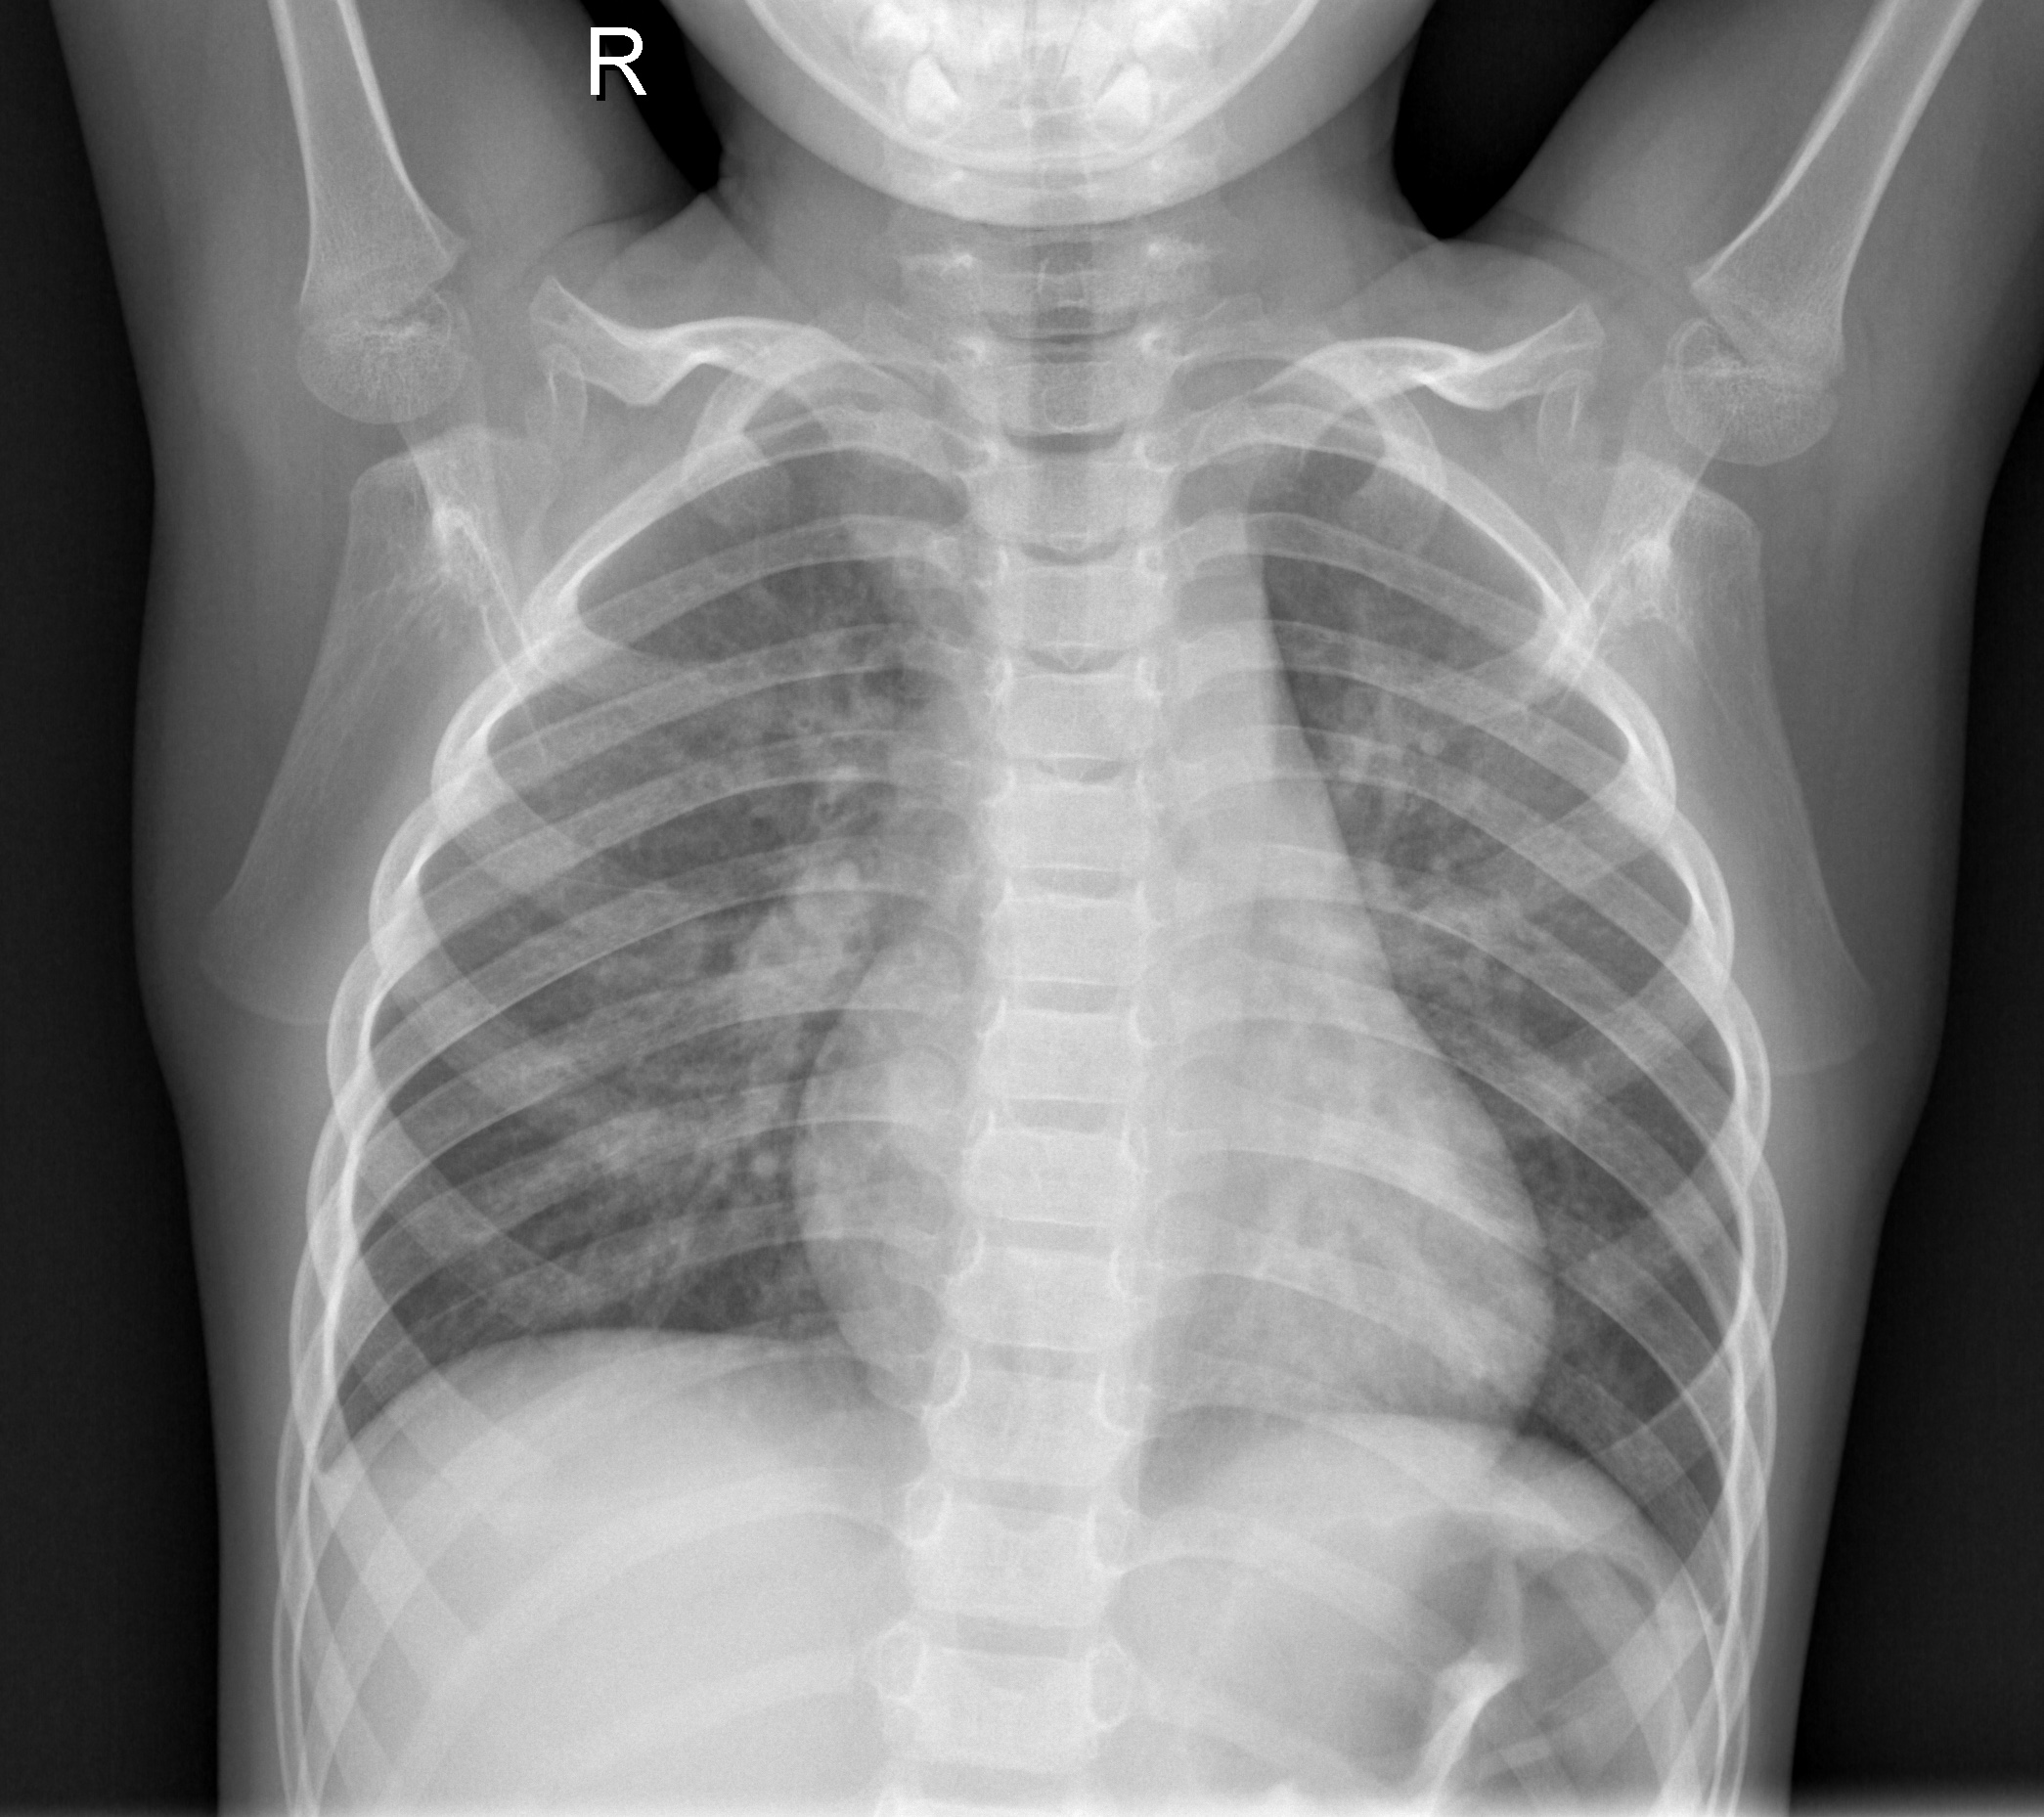

In [95]:
# Check a sample image.
dataset["train"][0]["image"]

### We will set a seed so that the generation is reproducable.

In [5]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Process the dataset

In [6]:
# GPU or CPU (Not having at least 1 GPU can prevent code from working)
device = torch.device("cuda:0" if (torch.cuda.is_available() and nb_gpu > 0) else "cpu")

# Models

First, we us define some parameters.

In [7]:
# Size of z latent vector (i.e. size of generator input), same size as described in the DCGAN paper
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 100

# Learning rate for optimizers, same value as described in the DCGAN paper
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers, same value as described in the DCGAN paper
beta1 = 0.5

The model weights sare randomly initialized from a Normal distribution with mean=0, stdev=0.02.
 These are applied to each layer of Generator and Discriminator.

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Define the Generator

In [9]:
# Generator Code
class Generator(nn.Module):
    def __init__(self, nb_gpu):
        super(Generator, self).__init__()
        self.nb_gpu = nb_gpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution

            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``

            nn.ConvTranspose2d(ngf, n_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nb_channels) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

## Create the generator

In [10]:
# Create the generator
netG = Generator(nb_gpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (nb_gpu > 1):
    netG = nn.DataParallel(netG, list(range(nb_gpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


## Define the Discriminator

In [11]:
class Discriminator(nn.Module):
    def __init__(self, nb_gpu):
        super(Discriminator, self).__init__()
        self.nb_gpu = nb_gpu
        self.main = nn.Sequential(
            # input is ``(nb_channels) x 64 x 64``

            nn.Conv2d(n_channels, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [12]:
# Create the Discriminator
netD = Discriminator(nb_gpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (nb_gpu > 1):
    netD = nn.DataParallel(netD, list(range(nb_gpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [13]:
# Real image and discriminator thinks it is real - Right decision
target = 1
output= 0.99

print(-(target * math.log(output) + (1-target)*math.log(1-output)))

# Real image and discriminator thinks it is fake - False decision
target = 1
output= 0.01

print(-(target * math.log(output) + (1-target)*math.log(1-output)))

# False image but discriminator thinks it is real - False decision
target = 0
output= 0.99

print(-(target * math.log(output) + (1-target)*math.log(1-output)))

0.01005033585350145
4.605170185988091
4.605170185988091


## We will use Binary Cross Entropy Loss as our loss function.

* BCELoss measures the difference between the predicted probabilities and the actual target values.


In [14]:
# Set real and fake label values (following GAN paper convention)
real_label = 1.
fake_label = 0.

# Define loss function
criterion = nn.BCELoss()

## Set up the Optimizers

In [15]:
# Setup optimizers for both G and D, according to the DCGAN paper
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## Training

### We initialize with random noise.

In [16]:
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

## Save the model checkpoints

In [17]:
# Flags - For each epoch
show_images = True
save_images = True
save_model = True

def save_dcgan(netG, netD, path_checkpoint):
    checkpoint = {"g_model_state_dict": netG.state_dict(),
                "d_model_state_dict": netD.state_dict(),
                }

    torch.save(checkpoint, path_checkpoint)

def makedir(new_dir):
  if not os.path.exists(new_dir):
    os.makedirs(new_dir)

# Create folders
makedir("images")
makedir("models")

## Create the training loop

Epoch: 0/100 Batches: 0/41	Loss_D: 1.3681   Loss_G: 3.0561    D(x): 0.4678    D(G(z)): 0.3667 / 0.0695


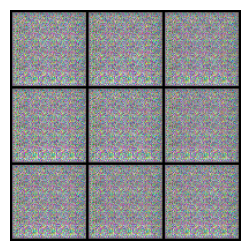

Epoch: 1/100 Batches: 0/41	Loss_D: 0.0049   Loss_G: 11.5493    D(x): 0.9962    D(G(z)): 0.0010 / 0.0000
Epoch: 2/100 Batches: 0/41	Loss_D: 0.0178   Loss_G: 20.9788    D(x): 0.9853    D(G(z)): 0.0000 / 0.0000
Epoch: 3/100 Batches: 0/41	Loss_D: 0.8470   Loss_G: 7.1215    D(x): 0.8441    D(G(z)): 0.4117 / 0.0014
Epoch: 4/100 Batches: 0/41	Loss_D: 0.2441   Loss_G: 2.9960    D(x): 0.8883    D(G(z)): 0.0945 / 0.0629
Epoch: 5/100 Batches: 0/41	Loss_D: 0.2746   Loss_G: 4.0211    D(x): 0.9819    D(G(z)): 0.2013 / 0.0356
Epoch: 6/100 Batches: 0/41	Loss_D: 0.7518   Loss_G: 2.1362    D(x): 0.6184    D(G(z)): 0.0825 / 0.1895
Epoch: 7/100 Batches: 0/41	Loss_D: 0.6973   Loss_G: 3.4397    D(x): 0.7567    D(G(z)): 0.2844 / 0.0627
Epoch: 8/100 Batches: 0/41	Loss_D: 0.9239   Loss_G: 6.2422    D(x): 0.9274    D(G(z)): 0.5207 / 0.0038
Epoch: 9/100 Batches: 0/41	Loss_D: 0.6555   Loss_G: 3.9355    D(x): 0.7783    D(G(z)): 0.2656 / 0.0289
Epoch: 10/100 Batches: 0/41	Loss_D: 0.4678   Loss_G: 3.2622    D(x): 0.

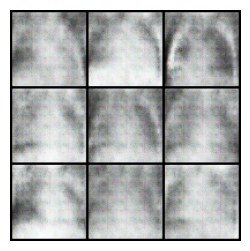

Epoch: 11/100 Batches: 0/41	Loss_D: 1.2469   Loss_G: 7.5968    D(x): 0.8818    D(G(z)): 0.6049 / 0.0019
Epoch: 12/100 Batches: 0/41	Loss_D: 0.5850   Loss_G: 3.2477    D(x): 0.6595    D(G(z)): 0.0797 / 0.0612
Epoch: 13/100 Batches: 0/41	Loss_D: 0.8577   Loss_G: 2.2934    D(x): 0.5605    D(G(z)): 0.0815 / 0.1984
Epoch: 14/100 Batches: 0/41	Loss_D: 0.5828   Loss_G: 4.7059    D(x): 0.7979    D(G(z)): 0.2476 / 0.0242
Epoch: 15/100 Batches: 0/41	Loss_D: 0.5831   Loss_G: 2.8136    D(x): 0.7447    D(G(z)): 0.1866 / 0.1004
Epoch: 16/100 Batches: 0/41	Loss_D: 1.3735   Loss_G: 7.4625    D(x): 0.9608    D(G(z)): 0.6898 / 0.0025
Epoch: 17/100 Batches: 0/41	Loss_D: 0.4791   Loss_G: 4.9785    D(x): 0.8567    D(G(z)): 0.2393 / 0.0125
Epoch: 18/100 Batches: 0/41	Loss_D: 0.4807   Loss_G: 3.7908    D(x): 0.9355    D(G(z)): 0.2906 / 0.0578
Epoch: 19/100 Batches: 0/41	Loss_D: 0.7430   Loss_G: 2.5881    D(x): 0.5672    D(G(z)): 0.0456 / 0.1468
Epoch: 20/100 Batches: 0/41	Loss_D: 0.5794   Loss_G: 4.3015    D

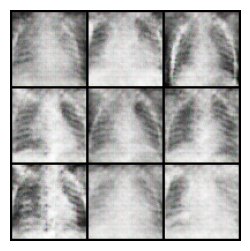

Epoch: 21/100 Batches: 0/41	Loss_D: 0.7129   Loss_G: 4.5561    D(x): 0.5821    D(G(z)): 0.0267 / 0.0397
Epoch: 22/100 Batches: 0/41	Loss_D: 0.5189   Loss_G: 2.9958    D(x): 0.7469    D(G(z)): 0.1584 / 0.0767
Epoch: 23/100 Batches: 0/41	Loss_D: 0.6773   Loss_G: 6.0395    D(x): 0.9211    D(G(z)): 0.4150 / 0.0088
Epoch: 24/100 Batches: 0/41	Loss_D: 0.5347   Loss_G: 3.1383    D(x): 0.6898    D(G(z)): 0.0640 / 0.0669
Epoch: 25/100 Batches: 0/41	Loss_D: 0.8515   Loss_G: 2.5017    D(x): 0.5359    D(G(z)): 0.0409 / 0.1335
Epoch: 26/100 Batches: 0/41	Loss_D: 0.5083   Loss_G: 3.5375    D(x): 0.7213    D(G(z)): 0.0897 / 0.0673
Epoch: 27/100 Batches: 0/41	Loss_D: 0.8368   Loss_G: 3.6106    D(x): 0.5306    D(G(z)): 0.0396 / 0.0606
Epoch: 28/100 Batches: 0/41	Loss_D: 0.7173   Loss_G: 5.6029    D(x): 0.9145    D(G(z)): 0.4100 / 0.0093
Epoch: 29/100 Batches: 0/41	Loss_D: 0.6023   Loss_G: 3.5380    D(x): 0.6445    D(G(z)): 0.0403 / 0.0570
Epoch: 30/100 Batches: 0/41	Loss_D: 0.3995   Loss_G: 4.0343    D

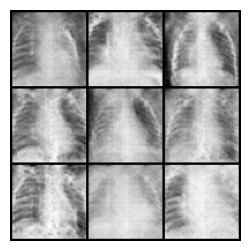

Epoch: 31/100 Batches: 0/41	Loss_D: 0.9151   Loss_G: 3.6843    D(x): 0.5283    D(G(z)): 0.0276 / 0.0908
Epoch: 32/100 Batches: 0/41	Loss_D: 0.6272   Loss_G: 4.7956    D(x): 0.8779    D(G(z)): 0.3467 / 0.0160
Epoch: 33/100 Batches: 0/41	Loss_D: 0.3640   Loss_G: 4.5130    D(x): 0.7634    D(G(z)): 0.0432 / 0.0263
Epoch: 34/100 Batches: 0/41	Loss_D: 0.7957   Loss_G: 6.9155    D(x): 0.9340    D(G(z)): 0.4798 / 0.0046
Epoch: 35/100 Batches: 0/41	Loss_D: 0.6770   Loss_G: 4.6480    D(x): 0.8590    D(G(z)): 0.3385 / 0.0316
Epoch: 36/100 Batches: 0/41	Loss_D: 0.4441   Loss_G: 4.7296    D(x): 0.8828    D(G(z)): 0.2516 / 0.0161
Epoch: 37/100 Batches: 0/41	Loss_D: 0.6128   Loss_G: 5.3636    D(x): 0.8413    D(G(z)): 0.3084 / 0.0173
Epoch: 38/100 Batches: 0/41	Loss_D: 0.3521   Loss_G: 4.3235    D(x): 0.8367    D(G(z)): 0.1191 / 0.0235
Epoch: 39/100 Batches: 0/41	Loss_D: 0.3311   Loss_G: 3.7397    D(x): 0.8257    D(G(z)): 0.1006 / 0.0646
Epoch: 40/100 Batches: 0/41	Loss_D: 0.5518   Loss_G: 3.0972    D

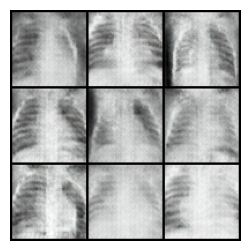

Epoch: 41/100 Batches: 0/41	Loss_D: 0.3984   Loss_G: 4.7390    D(x): 0.8974    D(G(z)): 0.2315 / 0.0139
Epoch: 42/100 Batches: 0/41	Loss_D: 0.3179   Loss_G: 4.4980    D(x): 0.8071    D(G(z)): 0.0506 / 0.0194
Epoch: 43/100 Batches: 0/41	Loss_D: 0.5696   Loss_G: 3.3639    D(x): 0.6680    D(G(z)): 0.0255 / 0.0934
Epoch: 44/100 Batches: 0/41	Loss_D: 0.3642   Loss_G: 4.6594    D(x): 0.8985    D(G(z)): 0.1949 / 0.0161
Epoch: 45/100 Batches: 0/41	Loss_D: 0.4788   Loss_G: 7.7526    D(x): 0.9614    D(G(z)): 0.3116 / 0.0014
Epoch: 46/100 Batches: 0/41	Loss_D: 0.2875   Loss_G: 3.9368    D(x): 0.9567    D(G(z)): 0.1984 / 0.0287
Epoch: 47/100 Batches: 0/41	Loss_D: 0.2155   Loss_G: 5.1989    D(x): 0.9077    D(G(z)): 0.0938 / 0.0181
Epoch: 48/100 Batches: 0/41	Loss_D: 0.3154   Loss_G: 3.8765    D(x): 0.8199    D(G(z)): 0.0782 / 0.0353
Epoch: 49/100 Batches: 0/41	Loss_D: 0.7825   Loss_G: 8.4024    D(x): 0.9791    D(G(z)): 0.4544 / 0.0006
Epoch: 50/100 Batches: 0/41	Loss_D: 0.3172   Loss_G: 3.9467    D

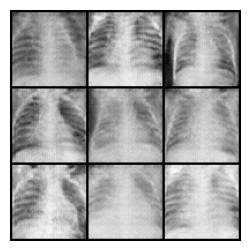

Epoch: 51/100 Batches: 0/41	Loss_D: 0.4868   Loss_G: 4.8030    D(x): 0.8429    D(G(z)): 0.2403 / 0.0213
Epoch: 52/100 Batches: 0/41	Loss_D: 0.5199   Loss_G: 4.9920    D(x): 0.9168    D(G(z)): 0.3088 / 0.0288
Epoch: 53/100 Batches: 0/41	Loss_D: 0.4344   Loss_G: 3.3484    D(x): 0.8014    D(G(z)): 0.1555 / 0.0552
Epoch: 54/100 Batches: 0/41	Loss_D: 0.8043   Loss_G: 2.5038    D(x): 0.5454    D(G(z)): 0.0115 / 0.1127
Epoch: 55/100 Batches: 0/41	Loss_D: 2.0076   Loss_G: 3.5064    D(x): 0.2327    D(G(z)): 0.0020 / 0.0905
Epoch: 56/100 Batches: 0/41	Loss_D: 1.4372   Loss_G: 3.5559    D(x): 0.3415    D(G(z)): 0.0055 / 0.1202
Epoch: 57/100 Batches: 0/41	Loss_D: 0.4586   Loss_G: 4.7564    D(x): 0.8640    D(G(z)): 0.2436 / 0.0249
Epoch: 58/100 Batches: 0/41	Loss_D: 0.3894   Loss_G: 3.9979    D(x): 0.7948    D(G(z)): 0.1004 / 0.0311
Epoch: 59/100 Batches: 0/41	Loss_D: 0.4898   Loss_G: 6.1205    D(x): 0.9350    D(G(z)): 0.3033 / 0.0043
Epoch: 60/100 Batches: 0/41	Loss_D: 0.3437   Loss_G: 3.5874    D

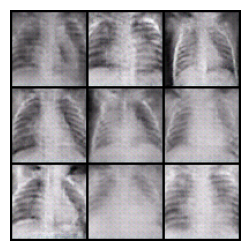

Epoch: 61/100 Batches: 0/41	Loss_D: 0.4154   Loss_G: 3.2041    D(x): 0.7666    D(G(z)): 0.0906 / 0.0719
Epoch: 62/100 Batches: 0/41	Loss_D: 0.4505   Loss_G: 3.2218    D(x): 0.7752    D(G(z)): 0.0987 / 0.0657
Epoch: 63/100 Batches: 0/41	Loss_D: 0.4528   Loss_G: 3.3544    D(x): 0.8194    D(G(z)): 0.1703 / 0.0577
Epoch: 64/100 Batches: 0/41	Loss_D: 0.5010   Loss_G: 6.3953    D(x): 0.9379    D(G(z)): 0.3182 / 0.0071
Epoch: 65/100 Batches: 0/41	Loss_D: 0.5887   Loss_G: 6.7123    D(x): 0.9377    D(G(z)): 0.3707 / 0.0039
Epoch: 66/100 Batches: 0/41	Loss_D: 0.1832   Loss_G: 3.2649    D(x): 0.9228    D(G(z)): 0.0800 / 0.0494
Epoch: 67/100 Batches: 0/41	Loss_D: 0.3279   Loss_G: 3.7189    D(x): 0.8330    D(G(z)): 0.1057 / 0.0491
Epoch: 68/100 Batches: 0/41	Loss_D: 0.3962   Loss_G: 2.6307    D(x): 0.7804    D(G(z)): 0.0836 / 0.0971
Epoch: 69/100 Batches: 0/41	Loss_D: 0.3377   Loss_G: 3.8482    D(x): 0.8548    D(G(z)): 0.1405 / 0.0409
Epoch: 70/100 Batches: 0/41	Loss_D: 0.2367   Loss_G: 4.2643    D

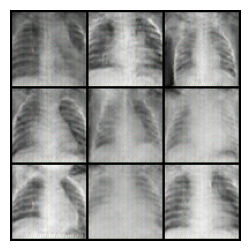

Epoch: 71/100 Batches: 0/41	Loss_D: 0.3483   Loss_G: 4.0384    D(x): 0.8489    D(G(z)): 0.1368 / 0.0380
Epoch: 72/100 Batches: 0/41	Loss_D: 0.3124   Loss_G: 3.2825    D(x): 0.7966    D(G(z)): 0.0436 / 0.0505
Epoch: 73/100 Batches: 0/41	Loss_D: 0.2512   Loss_G: 3.7366    D(x): 0.8813    D(G(z)): 0.0973 / 0.0381
Epoch: 74/100 Batches: 0/41	Loss_D: 0.2331   Loss_G: 4.3753    D(x): 0.8619    D(G(z)): 0.0596 / 0.0200
Epoch: 75/100 Batches: 0/41	Loss_D: 0.3036   Loss_G: 4.6863    D(x): 0.8860    D(G(z)): 0.1464 / 0.0160
Epoch: 76/100 Batches: 0/41	Loss_D: 0.3361   Loss_G: 4.8725    D(x): 0.9141    D(G(z)): 0.1927 / 0.0244
Epoch: 77/100 Batches: 0/41	Loss_D: 0.3557   Loss_G: 5.6474    D(x): 0.9471    D(G(z)): 0.2211 / 0.0076
Epoch: 78/100 Batches: 0/41	Loss_D: 0.3632   Loss_G: 5.8547    D(x): 0.9136    D(G(z)): 0.2134 / 0.0069
Epoch: 79/100 Batches: 0/41	Loss_D: 0.2461   Loss_G: 4.7534    D(x): 0.9263    D(G(z)): 0.1437 / 0.0166
Epoch: 80/100 Batches: 0/41	Loss_D: 0.9876   Loss_G: 10.1665    

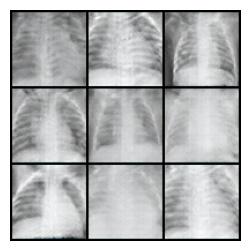

Epoch: 81/100 Batches: 0/41	Loss_D: 0.2343   Loss_G: 4.1431    D(x): 0.9033    D(G(z)): 0.1104 / 0.0268
Epoch: 82/100 Batches: 0/41	Loss_D: 0.2375   Loss_G: 4.3913    D(x): 0.8829    D(G(z)): 0.0789 / 0.0431
Epoch: 83/100 Batches: 0/41	Loss_D: 0.3391   Loss_G: 3.5050    D(x): 0.7706    D(G(z)): 0.0265 / 0.0454
Epoch: 84/100 Batches: 0/41	Loss_D: 0.2946   Loss_G: 3.8223    D(x): 0.8690    D(G(z)): 0.1083 / 0.0306
Epoch: 85/100 Batches: 0/41	Loss_D: 0.3161   Loss_G: 5.2071    D(x): 0.9246    D(G(z)): 0.1886 / 0.0080
Epoch: 86/100 Batches: 0/41	Loss_D: 0.3071   Loss_G: 4.5772    D(x): 0.8994    D(G(z)): 0.1614 / 0.0166
Epoch: 87/100 Batches: 0/41	Loss_D: 0.7130   Loss_G: 3.4760    D(x): 0.6467    D(G(z)): 0.0496 / 0.0734
Epoch: 88/100 Batches: 0/41	Loss_D: 0.5147   Loss_G: 6.6469    D(x): 0.9789    D(G(z)): 0.3482 / 0.0031
Epoch: 89/100 Batches: 0/41	Loss_D: 0.1938   Loss_G: 3.5537    D(x): 0.8915    D(G(z)): 0.0616 / 0.0624
Epoch: 90/100 Batches: 0/41	Loss_D: 0.2546   Loss_G: 3.1627    D

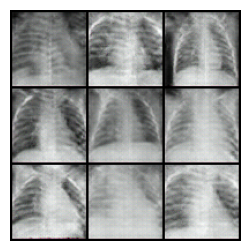

Epoch: 91/100 Batches: 0/41	Loss_D: 0.3737   Loss_G: 4.1320    D(x): 0.8499    D(G(z)): 0.1499 / 0.0245
Epoch: 92/100 Batches: 0/41	Loss_D: 0.4340   Loss_G: 6.2513    D(x): 0.9447    D(G(z)): 0.2681 / 0.0048
Epoch: 93/100 Batches: 0/41	Loss_D: 0.7863   Loss_G: 9.7622    D(x): 0.9869    D(G(z)): 0.4878 / 0.0005


In [ ]:
# Training Loop
data_len = len(dataloader)

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []


# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader (depends on batch_size and your number of images)
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data['image'].to(device)
        #real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        ############################
        # (3) Metrics & Evaluation
        ###########################

        # Print output training stats every 50 batches (if your dataset is large, printing at every epoch might be less frequent than you want)
        if i % 50 == 0:
            print(f"Epoch: {epoch}/{num_epochs} Batches: {i}/{data_len}\tLoss_D: {errD.item():.4f}   Loss_G: {errG.item():.4f}    D(x): {D_x:.4f}    D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}")

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

    # Generate fake images to see how the generator is doing by saving G's output on fixed_noise at each epoch (fixed noise allow to obtain similar images).
    if show_images == True and epoch % 10 == 0:
        with torch.no_grad():
            # Uncomment the line below to generate a new variety of images every time
            #fixed_noise = torch.randn(64, nz, 1, 1, device=device)

            fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake[:nb_images], padding=2, normalize=True, nrow=nb_row))

            plt.figure(figsize=(3, 3))
            plt.axis("off")
            plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))

            if save_images == True:
                plt.savefig(f'images/epoch_{epoch}_gen_images.png')

            # Display image
            plt.show()

    # Save models each 5 epochs
    if epoch % 5 == 0:
        if save_model:
            save_dcgan(netG, netD, path_checkpoint=f"models/chest_epoch_{epoch}_checkpoint.pkl")

# Save the final models
save_dcgan(netG, netD, path_checkpoint="models/chest_final_epoch_checkpoint.pkl")

## Define metrics

In [13]:
# sources:
# https://www.kaggle.com/code/ibtesama/gan-in-pytorch-with-fid/notebook
# https://github.com/mseitzer/pytorch-fid/blob/master/src/pytorch_fid/fid_score.py

import numpy as np
from scipy import linalg
from torch.nn.functional import adaptive_avg_pool2d


def calculate_activation_statistics(images, model, batch_size=128, dims=2048):
    model.eval()
    act = np.empty((len(images), dims))

    batch = images
    pred = model(batch)[0]

    # If model output is not scalar, apply global spatial average pooling.
    # This happens if you choose a dimensionality not equal 2048.
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act = pred.cpu().data.numpy().reshape(pred.size(0), -1)

    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma


def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2


    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))


    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)


def calculate_fretchet(images_real, images_fake, model):
    """Calculate the fretched distance."""

    # calculate statistics (mean + std)
    mu_1, std_1 = calculate_activation_statistics(images_real, model)
    mu_2, std_2 = calculate_activation_statistics(images_fake, model)

    # compute distance
    fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
    return fid_value

In [21]:
from IPython.display import HTML
import matplotlib.animation as animation
import matplotlib.pyplot as plt

## Plot losses

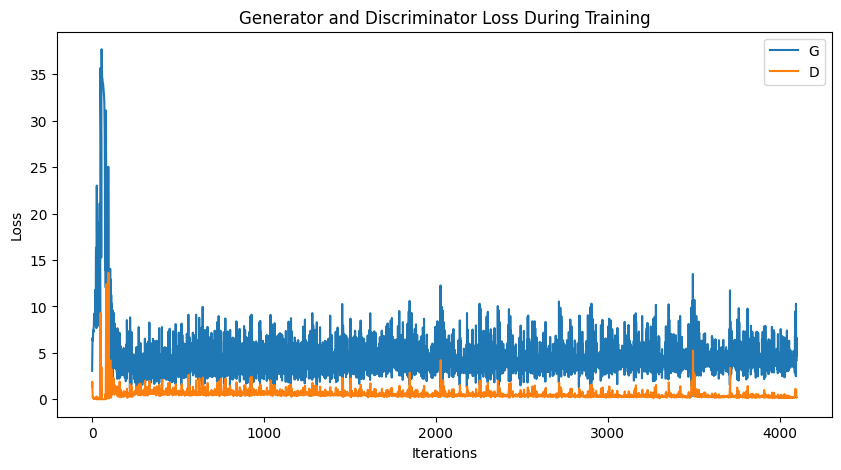

In [22]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [23]:
# increase the default limit set by Matplotlib for embedding animations
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 100  # 100 MB

## Follow the training

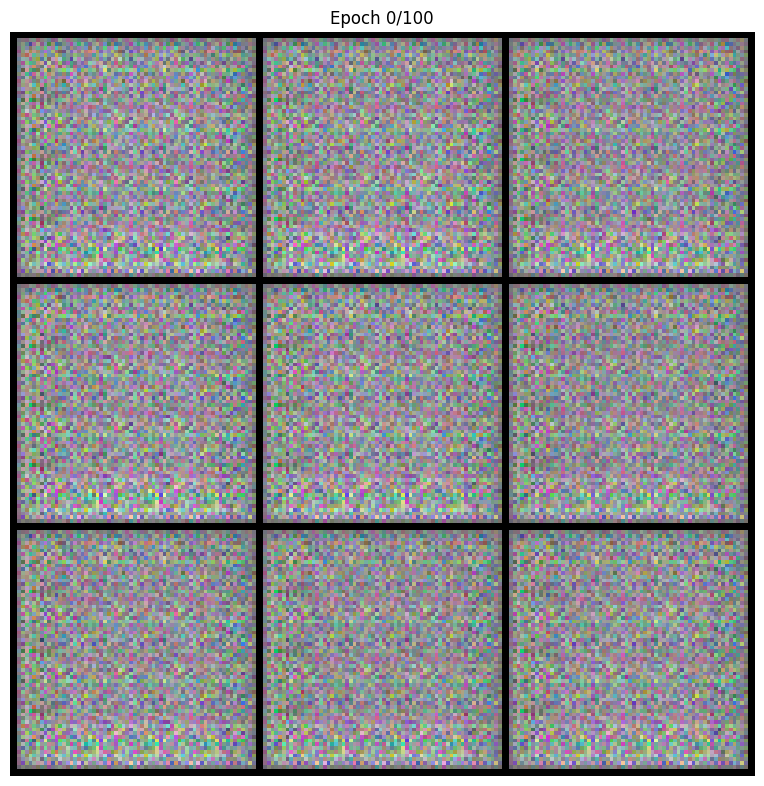

In [24]:
fig = plt.figure(figsize=(8, 8))
plt.axis("off")
plt.tight_layout(pad=2.0, h_pad=2.0, w_pad=2.0)

# Initial empty title and image
title = plt.title("")
img_plot = plt.imshow(np.transpose(img_list[0], (1, 2, 0)), animated=True)

def update_title_and_image(frame):
    img_plot.set_array(np.transpose(img_list[frame], (1, 2, 0)))
    title.set_text(f"Epoch {frame}/{num_epochs}")

ani = animation.FuncAnimation(fig, update_title_and_image, frames=len(img_list), interval=100, repeat_delay=5000)

# Display animation
HTML(ani.to_jshtml())

In [25]:
# Save the animation as a GIF
ani.save('images/dcgan_training_animation.gif', writer='pillow')

## Inference

In [26]:
# Specify desired weights path
path_checkpoint = "models/chest_final_epoch_checkpoint.pkl"

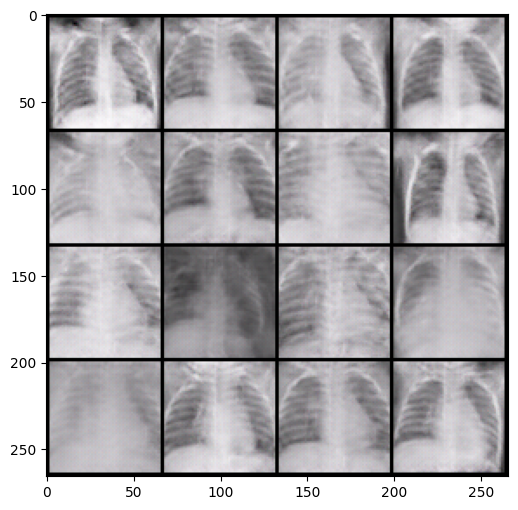

In [27]:
# Number of desired images
num_img = 16
nb_row = math.ceil(math.sqrt(num_img))

# Create a random noise
random_noise = torch.randn(num_img, nz, 1, 1, device=device)

# Instantiate a generator
new_gen= Generator(nb_gpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (nb_gpu > 1):
    new_gen = nn.DataParallel(new_gen, list(range(nb_gpu)))

# Load weights from path
checkpoint = torch.load(path_checkpoint, map_location="cpu")
state_dict_g = checkpoint["g_model_state_dict"]
new_gen.load_state_dict(state_dict_g)

# Generate images
with torch.no_grad():
    fake_data = new_gen(random_noise).detach().cpu()

# Plot images
img_grid = vutils.make_grid(fake_data, padding=2, normalize=True, nrow=nb_row).cpu()
img_grid = np.transpose(img_grid, (1, 2, 0))
plt.figure(figsize=(6, 6))
plt.imshow(img_grid)
plt.show()

## Post Processing

In [28]:
# Instantiate a discriminator
new_dis= Discriminator(nb_gpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (nb_gpu > 1):
    new_dis = nn.DataParallel(new_dis, list(range(nb_gpu)))

# Load weights from path
checkpoint = torch.load(path_checkpoint, map_location="cpu")
state_dict_d = checkpoint["d_model_state_dict"]
new_dis.load_state_dict(state_dict_d)

<All keys matched successfully>

## Find verified images

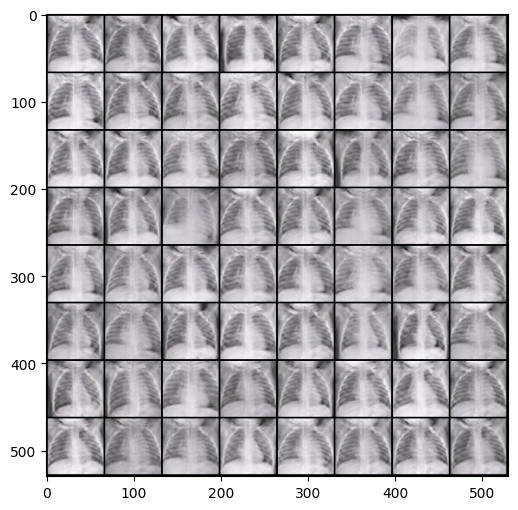

In [29]:
# Set threshold
threshold = 0.70


# Create list to store the images classified as >= threshold
verified_images = []

# Till we do not have 64 images

while len(verified_images)<64:
    # Create a random noise
    random_noise = torch.randn(num_img, nz, 1, 1, device=device)
    # Generate images for this noise
    with torch.no_grad():
        fake_data = new_gen(random_noise)

        # Set the discriminator to eval mode
        new_dis.eval()

        # Pass the generated fake_data through the discriminator & obtain real/fake probabilities
        output_probabilities = new_dis(fake_data)

    # Create mask (If prob < threshold, set to False, else True)
    good_image_mask = output_probabilities >= threshold

    # Remove extra tensor dims (torch.Size([16, 1, 1, 1]) -> torch.Size([16]))
    good_image_mask = good_image_mask.squeeze()

    # Keep the selected images
    good_images = fake_data[good_image_mask > threshold]

    # If good_images is not None
    if good_images.numel() > 0:
        # Loop through the tensor along the first dimension (index 0), since we have x images in a torch.Size([x, 3, 64, 64]) object
        for i in range(good_images.size(0)):
            # Add selected images
            verified_images.append(good_images[i])

# Plot selected images
img_grid = vutils.make_grid(verified_images, padding=2, normalize=True, nrow=8).cpu()
img_grid = np.transpose(img_grid, (1, 2, 0))
plt.figure(figsize=(6, 6))
plt.imshow(img_grid)
plt.show()